# The Practical Man's Guide to Binary Classification

The objective of this book is to guide you through the steps of solving the most common type of problem in applied machine learning: binary classification.

It assumes you have a basic understanding of how machine learning works - i.e. you have split a dataset into train/test and trained a model in `sklearn` before - but does not assume you know much about binary classification, the metrics we can use to model it, or the common pitfalls. That is our job to teach you. 

### Warning: how much math do I need for this book?

To do machine learning, you don't need to know a lot of math. But to do machine learning *well* you certainly need it, and this book assumes you have enough mathematical maturity to understand the notation and logic we employ.

You can still profit from the discussion without much math - just focus on the takeaways. However, it is obvious that the reader who has taken mathematical probability or statistics and undergraduate calculus will be able to appreciate the more technical aspects of the explanation. If you can understand the definitions below:
* $\displaystyle \mathbb P (A|B) = \frac{\mathbb P(A \cap B)}{\mathbb P (B)}$
* $\displaystyle \mathbb E[g(X)] = \int_{-\infty}^\infty g(x) f(x) dx$
* $F(x) := \mathbb P (X \leq x)$
* $\displaystyle f(x) = \frac{d F(x)}{dx}$

then you are probably good to go. If you need a refresher, http://cs229.stanford.edu/section/cs229-prob.pdf might be a good reference.

### Version compatibility

We use `scikit-learn` version 1.0.2. The code here should be replicable with versions 1.0.2 or higher.

In [1]:
import sklearn
print(sklearn.__version__)

1.0.2


---

## The standard classification setup

Binary classification is the task of predicting whether a thing belongs to one class or another. For the sake of simplicity, we will call one of them 1 (the **positive class**) and the other one 0 (the **negative class**); sometimes, especially when we discuss imbalanced datasets, class 1 will also be called the **minority class**. We avoid the convention (mostly used when discussing support vector machines) of labelling the classes 1 and -1, although that convention could be used here with simple adaptations of most formulas.

The most common situation is that where we have a set of datapoints $\{x_i,y_i\}_{i\in 1:N}$ (where we denote as $1:N$ the set of integers between 1 and N). Here, the **features** $x_i$ are assumed to live in some $d$-dimensional space $\mathcal{X}$ (which may contain discrete inputs, images, etc) and the **target** $y_i$ (also called **label**) assumes the values 0 or 1.

Our goal is to train a function which can predict, for a new sample $x$, whether its label should be 0 or 1. 
> Note on notation: we don't write the features as $\vec{x}_i$ or $\mathbf{x}_i$ to explicitly denote they are vectors - the discussion here independs on whether there are 1 or 1000 features and will not depend on the specific vectorial nature of the feature space.

## Where does classification go wrong?

Binary classification should be the easiest problem in machine learning. It is. But it is also one of the most important as well as one where people make most mistakes. In fact, it is my belief that knowledge on linear regression and classification problems correlates with data science capability. 

There are three points people often get wrong in classification models:

1. **Class imbalance**: when one of the classes is much less represented than the other. For example, in a standard problem in fraud detection, maybe 0.5% of the total points will be labeled as fraudulent ($y=1$) whereas all the others are not frauds $(y=0)$. Class imbalance nearsights most metrics, and makes it hard to say which model is better.

2. **Bad choice of metric(s)**. You can find thousands of Medium articles going over all the important classification metrics. This book here is no different. Yet, too many choices usually lead us to make bad choices. It is surprising how hard it can be to choose and interpret metrics in classification problems.

3. **Bad problem definition**. In real business problems, the class $y$ is not given to you. You must define a policy or set of rules to establish when a point will be considered a 1 and when it will be considered a 0. This definition might work for a while, but might also be fluid in time. Understanding your choice of target and making sure it is the "right" one is a complex business issue.

---

# Classification model theory

## The probabilistic point of view

Most (if not all) machine learning problems can be written, and better understood, in the language of probability theory. Since this will be our main language in this document too, we will briefly present the main ingredients, to the necessary degree of mathematical rigor.

We assume there exist some (unobserved, theoretical) random variables $(X, Y)$ which are jointly distributed (we follow the convention of writing random variables with uppercase letters, and their instances / observations in lowercase), with $Y$ taking values in $\{0,1\}$.

Our goal is to estimate the so-called **score** of an observation $x$:

$$\boxed{p(x) := \mathbb{P}(Y=1|X=x)},$$

or, translating into words:

> Given a set of features $x$, what is the probability that we measure $Y$ to be 1? 

Notice that $p(x)$ tells the whole story about the distribution of $Y$ given $X$, since $\mathbb{P}(Y=0|X=x) = 1-p(x)$



### Bernoulli variables : mathematical coin tosses

An equivalent, rigorous description of the above is that variable $Y|X=x$ (read as "$Y$ given that $X$ equals $x$") follows a **Bernoulli distribution** with parameter $p(x)$, which we write
$$
\boxed{(Y|X=x) \sim \mathrm{Bernoulli}(p(x))}
$$

This equation is the basis for everything we do in binary classification (which really amounts to finding $p(x)$ via several methods), so remember it.

> Notice how the rather cumbersome notation "$Y|X=x$" denotes a perfectly well-defined random variable: it is the values we observe for $Y$ provided that $X$ has been measured to be $x$. Notationally, if we call $Z \equiv Y|X=x$, then the statement $\mathbb{P}(Z=y)$ is equivalent to $\mathbb{P}(Y=y|X=x)$.

A variable $Z$ follows a Bernoulli distribution with parameter $p$ (between 0 and 1), which we write as $Z \sim \mathrm{Bernoulli}(p)$, if $Z$ takes values in $\{0,1\}$ and 

$$\mathbb{P}(Z=1) = p,\qquad \mathbb{P}(Z=0) = 1-p$$

or more succinctly,
$$\mathbb{P}(Z=k) = p^k (1-p)^{1-k}, \qquad k \in \{0,1\}.$$

(it is also common to write $\mathbb{P}(Z=k;p)$ to make explicit that we are using $p$ as a parameter)

A Bernoulli trial (which is how a sample from a Bernoulli variable is called) is the equivalent to a coin toss. Letting heads = 1 and tails = 0, then $p$ is the probability of seeing a heads, and $1-p$ is that of seeing a tail.
A fair coin has $p=1/2$.

Notice how, in our case, $Z(x)\equiv (Y|X=x)$ is a function of $x$ - that is why we see $p(x)$ entering a parameter. This means that our "coin" has a parameter which is not constant, and it changes from point to point in the feature space. That makes sense - consider the problem of predicting if someone has (1) or does not have (0) a car, given their income. Then one would expect $p(\mbox{high income}) > p(\mbox{low income})$, for example.

### Binary classification is not really that binary

In binary classification we try to predict a score, which is a number $p(x)$ between 0 and 1. It is, for most inputs $x$, neither 0 or 1, but something in between. 

This means that even though our labels $y$ must be either 0 or 1, what we calculate is a continuous score. If we want to "binarize" this output, we need to choose a **threshold** (which we'll write as $\lambda$) to create a rule:

$$\hat{y}(x) = \begin{cases}
1 & \mbox{if } f(x) \geq \lambda \\
0 & \mbox{if } f(x) < \lambda
\end{cases}
$$



Here, $\hat{y}(x)$ is the **estimator** for $(Y|X=x)$ - it is the value we predict, and this one only takes the value of 0 or 1. What the equation above really means is: if the score is larger than the threshold, set the prediction to 1, otherwise set it to 0.

More precisely, we could write $\hat{y}(x)$ as $\hat{y}_\lambda(x)$ since it depends on the choice of the threshold. We will sometimes use this notation.

### Wrap-up of our ingredients

* **Data**: dataset $\{x_i, y_i\}_{i\in 1:N}$ of features and labels, where all labels $y_i$ take values in $\{0,1\}$
* **Model**: we assume there exists a function $p$ such that $(Y|X=x) \sim \mathrm{Bernoulli}(p(x))$. To fully solve the classification problem, we must choose:
  * The score function $p(x)$
  * The threshold $\lambda$ to create the estimator $\hat{y}_\lambda(x)$

In the next chapters, we focus on methods to find and assess score functions, as well as choosing the best threshold (in some sense).

___

# The loss function: binary cross-entropy

Not any random score $p(x)$ will do. We want to find the "best" score function, but first we must define what that means in the first place.

Intuitively, the picture should be clear. Suppose we have a random point in our dataset $(x_{23}, y_{23})$ with $y_{23}=1$. One would expect a good function $p$ to provide a high score for this point, eg. $p(x_{23}) = 0.97$, that is, there is a very high probability that $y_{23}$ is 1. 

Similarly, for another instance $(x_{8}, y_8)$ with $y_8=0$, one would expect a low score, maybe $p(x_8) = 0.04$.

In machine learning, the process of **training** a model requires us to choose a **loss function**: a function which takes high values for bad models that make lots of mistakes, and takes low values for good models. Then, we can deal with the task of choosing a model that minimizes the loss (I am ignoring matters of model regularization here).

> (**Review - loss functions & regularization**) *Loss functions* are a common ingredient in machine learning. Basically, they are a means to estimate how far away from a perfect solution we are. More precisely, if we are trying to find a function $f$ (which will be the ground truth), and we estimate that a function $g$ might be a good approximant, then the loss is a function $L[g]$ which is positive, and is minimized for $g=f$. 
> If one is given a training set $\{x_i, y_i\}_{i\in 1:N}$, the expression for the loss is usually broken down into $N$ separate components: $\displaystyle L[g] = \frac{1}{N} \sum_{i=1}^N l(y_i, g(x_i))$, where $l(y, g(x))$ calculates the error between point $y$ and its estimate $\hat y = g(x)$. The choice of $l$ is such that $l(y,\hat y)=0$ if $\hat y = y$, ie. the model perfectly replicates the training data, and $>0$ otherwise. 

> In practice, one usually introduces *regularization* to avoid overfitting: this comes from considering a penalized version of the loss which penalizes exceedingly complex function approximants $g$: $$L_\mathrm{reg}[g] = \frac{1}{N} \sum_{i=1}^N l(y_i, g(x_i)) + \lambda R[g],$$
where $R > 0$ is the regularization term and $\lambda > 0$ is a weight. More explicitly, let $g = g_\theta$ actually depend on a set of parameters $\theta$ (which could be the coefficients of a logistic regression, for example). Then one usually sets $R[g]$ to some power of (the norm of) $\theta$, thus penalizing large values of the parameter.

#### Simple case: Bernoulli variable

Forget about features for a second. Suppose we have a sequence of 23 observations 

$$11011010100010010010111$$ 

for a Bernoulii variable (eg. a sequence of coin tosses). How can we best estimate $p$ (which here is just a parameter)? More intuitively: given a sequence of heads and tails, how to best estimate the bias of the coin?

The solution comes from inferential statistics, via the method of **maximum likelihood estimation** (MLE). The idea is simple: find the parameter which makes it most likely to see this set of observations.

> (**Review - Maximum likelihood estimation**) In statistics, MLE is a method used in the following situation: we are given a set of observations - data - for which we have a hypothesis of the generating distribution. For instance, we might believe that a set of points has come as samples from a normal distribution. Remember: a normal distribution is fully specified by two parameters $\mu$ and $\sigma^2$, which describe its mean and variance. In our case, we wish to find which normal distribution - hence which values of $\mu$ and $\sigma^2$ - are most appropriate for the data we observe. MLE, as shown below, allows us to find a function (the likelihood) which, when maximized over all possible parameters, give those which best fit our data. Mathematically, if we observe points $x_1, \ldots, x_n$ which are taken to be iid, and want to fit a distribution $f_\theta(x)$ to them, then the likelihood is the function $\ell(\theta) = \sum_{i=1}^n \log f_\theta(x_i)$; one then finds the maximum likelihood estimate via $\hat \theta_{\mathrm{MLE}} = \mathrm{arg} \max_\theta \ell(\theta)$.

Let's give some names to things. Let $N=23$, and let $Y_i$, for $i \in 1:N$, be a set of identical and independently distributed (iid) Bernoulli variables with parameter $p$, that is

$$Y_i \sim \mathrm{Bernoulli}(p)\qquad\mbox{ for all $i$, with $Y_i$ independent of $Y_j$ for $i\neq j$}$$

Also call $y_1, y_2,\ldots, y_{23}$ the observed values for each of the $Y_i$, meaning 

$$y_1 = 1,\quad y_2 = 1, \quad y_3=0,\ldots$$

Then, the probability of obtaining the observed sequence is

$$\begin{align}
\mathbb{P}(Y_1=y_1, Y_2=y_2,\ldots, Y_n=y_n) &= \mathbb{P}(Y_1=y_1) \mathbb{P}(Y_2=y_2)\cdots \mathbb{P}(Y_N=y_N)\quad\mbox{due to independence}\\
&= \prod_{i=1}^N \mathbb{P}(Y_i=y_i)\quad \mbox{ simplifying notation}\\
&= \prod_{i=1}^N p^{y_i}(1-p)^{1-y_i} =: \mathrm{likelihood}(p)
\end{align}
$$

where we have defined the **likelihood function** of $p$ in the last line. Indeed, notice that since the $y_i$ are fixed, the likelihood is just a function of $p$.

A common trick to simplify equations (and to induce convexity) is to take the log of both sides, defining the **log-likelihood**. Then the product simplifies to a sum, and we have

$$\ell(p) \equiv \log \mathrm{likelihood}(p) = \sum_{i=1}^N \left[y_i \log p + (1-y_i) \log(1-p)\right]$$

The MLE method proposes to maximize this quantity. But we can just as well take its negative sign and propose to *minimize* it instead, and name it our loss function!

$$L(p) = - \sum_{i=1}^N \left[y_i \log p + (1-y_i) \log(1-p)\right]$$

Our problem then becomes: find $p$ such that the loss function above is minimized. This can be done via some calculus:

$$L'(p) = - \sum_{i=1}^N \left[ \frac{y_i}{p} - \frac{1-y_i}{1-p}\right] = 0 \Rightarrow \boxed{\hat{p} = \frac{1}{N} \sum_{i=1}^N y_i}$$

Thus, the MLE estimator for the Bernoulli problem is extremely simple: just the arithmetic average of the observations. This is indeed what we could intuitively expect. $p$ measures the proportion of times we got a 1 instead of a 0.

In [2]:
# Estimate p via MLE for our case
import numpy as np

y = np.array([1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1])
print("p_MLE = %.2f" % y.mean())

p_MLE = 0.52


### Generalizing the Bernoulli result: binary cross-entropy 

We can take the reasoning above beyond the "no-features" Bernoulli model, simply because the line of thought is exactly the same, changing $p$ for $p(x_i)$ and $Y_i$ for $Y_i|X_i = x_i$. The loss we get this time is

$$\boxed{L = - \sum_{i=1}^N \left[y_i \log p(x_i) + (1-y_i) \log(1-p(x_i))\right]}$$

which is called by the fancy name **binary cross-entropy** or simply **log-loss**.

Two important questions appear immediately:
  - 1) What is the log-loss a function *of*? With respect to what should we minimize it?

  - 2) How good is the log-loss as a choice of a loss function for binary classification?

#### Answer to 1: Parametric models

In 99% of the cases, we model the score function $p$ with some set of parameters, which we will collectively denote by $\theta$, and write as $p_\theta(x)$. A few examples:

* In logistic regression, we explicitly write
$$p_\theta(x) = \frac{1}{1 + \exp(-\theta_0 - \sum_{a=1}^M \theta_a x_a)}.$$
Here, $\theta$ is the set of coefficients $\theta_0, \theta_1, \ldots, \theta_M$.

* In a classification tree, we separate the feature space in hypercubes. $\theta$  are the set of splitting variables and thresholds chosen.


In this scenario, one writes $L = L(\theta)$ and finds (numerically, if needed) the solution to


$$\frac{\partial L}{\partial \theta_a} = 0 \quad \mbox{ for all $a$}.$$

Once the optimal $\hat{\theta}$ has been found via this method, we can explicitly insert them in $p_\theta$ and our job is done. Some methods to solve equations such as the one above include Newton's method and gradient descent (and its variations).

#### Answer to 2: weights

The standard log-loss equation weighs all samples $i$ equally. It might happen that one wants to penalize a subset of points more than others; this is usually the case in imbalanced learning, where the number of points with $y=1$ is much smaller than that of $y=0$ (we call $y=1$ the minority class here). Then, one might choose to add more weight to errors in that class, since it is a harder class to predict.

The equation gets then modified to

$$L = - \frac{\sum_{i=1}^N w_i \left[y_i \log p(x_i) + (1-y_i) \log(1-p(x_i))\right]}{\sum_{i=1}^N w_i}$$

for some set of pre-determined weights $w_i$.

In `scikit-learn`, when choosing to use the log-loss, one can explicitly pass weights via the `sample_weight` attribute (similarly in other libraries, eg. LightGBM has an option `scale_pos_weight` to choose the weight of the positive class). 

To illustrate this, given our ground truths, suppose that we have built a model with some predictions (for $p(x_i)$!)

In [3]:
y      = np.array([1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1])    # true values
y_pred = np.array([0.90, 0.10, 0.05, 0.80, 0.85, 0.03, 0.01, 0.08, 0.88, 0.98, 0.12, 0.20, 
                   0.10, 0.20, 0.11, 0.79, 0.25, 0.98, 0.16, 0.10, 0.78, 0.98, 0.01])       # our predictions

Now we can calculate the standard log-loss, with equal weights:

In [4]:
from sklearn.metrics import log_loss

print("Standard log-loss: %.2f" % log_loss(y_true=y, y_pred=y_pred))

Standard log-loss: 1.12


If we choose to weigh the $y=1$ class twice as much as the $y=0$ class, we can pass that as an optional argument:

In [5]:
weights = np.where(y==1, 2, 1)  # weight = 2 for y=1, and weight = 1 for y=0
print("Weighed log-loss: %.2f" % log_loss(y_true=y, y_pred=y_pred, sample_weight=weights))

Weighed log-loss: 1.22


The value is now higher: our model does a slightly worse job at predicting class 1 than class 0.

### Is log-loss the only loss?

In practice, **yes** - the classification algorithms you see out there all minimize (weighted) cross-entropy during training.

It is not, however, the only *metric*. There are several metrics (ROC AUC, Precision / Recall, $F_1$ to name a few) which can be used to assess how good a model is. 

### Why do we call $p(x)$ the "score"?

It would be more intuitive, perhaps, to call $p(x)$ a probability. Indeed, it is a type of probability: the probability that $Y=1$ given that $X=x$.

The main reason we call it a score is that most algorithms **do not estimate the probability $p(x)$ directly**. Logistic regression is one of the few algorithms which do, but most of the useful ones - random forests, gradient boosted trees, neural networks - do not. In this case, we are actually predicting a modified version of $p(x)$. To make the discussion simpler, we will call everything a score, and leave the discussion of actually estimating probabilities to the chapter on calibration.
> Indeed, for many use cases (such as credit scoring, product recommendations, or fraud detection) actual probababilities are not that important; rather, their *ordering* is. So it wouldn't matter that my probability of defaulting on a payment is 15%; what matters is that it is 15% while my friend Bob's is 30%, hence mine is *lower* (by how much, we don't know). This is not the case for insurance, for example, where actual expected values need to be calculated. We will discuss this later.


----

# Classification metrics

Recall that the threshold is the number $\lambda$ such that we set the model's prediction to 1 if the score is greater than $\lambda$, and 0 otherwise.

Why do we split our discussion between threshold dependent and independent metrics?

There are two reasons:

1. In the modelling pipeline, finding a continuous score model comes first - only after that comes defining a threshold. Usually, one picks the best model in a threshold-independent way. If the application requires them to define a binary output (which is not always the case), then one tries to find a good threshold *after* the model has been chosen.

2. There is no "best" threshold - it will be found as the result of a calculation including trade-offs (between false positives vs false negatives, for example). Because of this, it is better to keep the discussion of how to find a threshold to later.

Thus, we start with a good understanding of threshold-independent metrics. These are *usually* the most important, the ones you see published, and that make an actual business impact.


## Our sample data

Throughout this section, we will use the following simulated data with 10 features and 1000 data points, out of which only 8 are meaningful:

In [6]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# create dummy classification problem
X, y = make_classification(n_samples=5000, n_features=10, n_informative=8, n_redundant=1, n_repeated=1, 
                           random_state=10) # for reproducibility

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

## The base ingredient: confusion matrices

All metrics will be build from a single fundamental element: the confusion matrix.

Basically, assume for a second you have an estimator $\hat y(x)$. This supposes you have created a score function and chosen a threshold, so that $\hat y(x)$ will give 1's and 0's. 

Now, given an observation $(x, y)$ (with $y$ equal to 0 or 1) there are **four possible outcomes** when we compare the real $y$ to the prediction $\hat y(x)$:

1. $y=0$ and $\hat y = 0$: right prediction. This is called a **true negative (TN)** (since we also call the class 0 the "negative class")
2. $y=0$ and $\hat y = 1$: wrong prediction. This is called a **false positive (FP)** (since we falsely predicted the class 1, also known as the positive class)
3. $y=1$ and $\hat y = 0$: wrong prediction. This is called a **false negative (FN)**.
4. $y=1$ and $\hat y = 1$: right prediction. This is called a **true positive (TP)**.

These 4 possibilities can be stored in a 2x2 matrix called the **confusion matrix**. We illustrate below how to build one in `scikit-learn`.

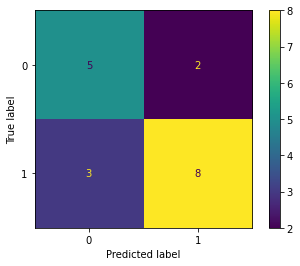

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pylab as plt

# assume we have a series of observed and predicted labels
y_real = [1,1,1,1,0,0,1,0,1,0,1,0,1,1,1,1,0,0]
y_pred = [1,1,0,1,0,1,1,0,1,0,1,1,1,0,0,1,0,0]

# first we build a confusion matrix object...
matrix = confusion_matrix(y_real, y_pred)

#... which we then plot
ConfusionMatrixDisplay(matrix).plot()
plt.show()

#### --- Mathematical interlude ---

Assume we have $N$ iid observations $\{x_i, y_i\}_{i\in1:N}$. We can define a *normalized estimator* of true positives as

$$\frac{\mathrm{\widehat{TP}}}{N} := \frac{1}{N} \sum_{i=1}^N \mathbf{1}_{\hat{y} (x_i) = 1 \cap y_i=1}$$

where the indicator variable $\mathbf{1}_A$ is 1 if $A$ is true and 0 if it is false. Here, it will be one if both $y_i$ and the estimate $\hat{y}(x_i)$ are 1.

Why normalized? Because in practice the total amount of true positives (or any other cell of the confusion matrix for that matter) doesn't really matter. What matters are their ratios, and this should stay true as $N$ grows larger. Thus, even though you will see expressions such as $\mathrm{TP/(TP+FN)}$ below and in many other sources, you should really take them to be $\mathrm{\widehat{TP}}/N/(\mathrm{\widehat{TP}}/N + \mathrm{\widehat{FN}}/N)$.

**Proposition**. $\mathrm{\widehat{TP}}/N$ is an unbiased estimator of $\mathbb{P}(\hat y(x)=1 \cap y = 1)$.
> Proof: taking the expectation, and using that $\mathbb{E}[\mathbf{1}_A] = \mathbb{P}(A)$, we get
$$\mathbb{E} \left[\frac{\mathrm{\widehat{TP}}}{N} \right] = \frac 1N \sum_{i=1}^N \mathbb{E}[\mathbf{1}_{\hat y(x_i) = 1 \cap y_i = 1}] = \frac NN \mathbb{P} (\hat y(x_i) = 1 \cap y_i = 1) = \mathbb{P} (\hat y(x_i) = 1 \cap y_i = 1),$$
where we were able to break the sum into $N$ copies of the summand from the hypothesis of independence between the samples.

These results will be important when creating metrics from the confusion matrix, in particular in the discussion about ROC AUC.

**--- end of interlude ---**

### A quick disclaimer: `predict` vs. `predict_proba`

In `scikit-learn` (and `scikit-learn`-friendly libraries such as XGBoost and LightGBM) all classifiers contain at last two methods: `predict` and `predict_proba`. 

Their difference is straightforward: `predict` returns the predicted classes (0 or 1 in the binary case) whereas `predict_proba` returns a float between 0 and 1, with the score.
> For most models, the output of `predict_proba` is **not** a probability, but simply a score. We will discuss this better in the calibration section.

To exemplify this, let's use a simple logistic regression model and see how it works.

In [8]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [9]:
x = X_train[25,:].reshape(1,-1) # take one training sample for us to predict
model.predict(x)

array([1])

In [10]:
model.predict_proba(x)

array([[0.12682433, 0.87317567]])

What `predict_proba` does is output two values: the probability that the $y=0$ given $x$ (12.7% here), and the probability of $y=1$ given $x$ (87.3%). In other words, it outputs $(1-\mbox{score}, \mbox{score})$. 
> Since we are in a binary case, we can just extract the last component via `model.predict_proba(x)[:,1]`, since the 0th component will be fully determined by it. In the multiclass case (with more than two classes) then it is important to have all components given.

What `predict` does is to take the result of `predict_proba` and binarize it - essentially by just **applying a threshold of 0.5**! In order to keep things within our control, we recommend to simply use the predicted score via `predict_proba` and then feed it to different metrics.

In [11]:
y_train_pred = model.predict_proba(X_train)[:,1]
y_test_pred = model.predict_proba(X_test)[:,1]

### How well did our model do?

Looking into the documentation, you might be tempted to use the model's `.score` function:

In [12]:
print(">> Don't use this function")
print("Train score: {}".format(model.score(X_train, y_train)))
print("Test score: {}".format(model.score(X_test, y_test)))

>> Don't use this function
Train score: 0.6762857142857143
Test score: 0.668


But we recommend you to never use the `score` function - since under the hood it calculates accuracies with the `predict` function, which we don't recommend.

Instead, we will present you with three useful threshold-independent metrics in what follows: the ROC AUC, average precision, and lift/delinquency curves.
> We recommend you always use them all for your model assessments

### Ratios of the confusion matrix

For now, fix a confusion matrix (this amounts to fixing an estimator $\hat y(x)$, or equivalently, to training a score function $p(x)$ and fixing a threshold). One could ask questions such as: out of all the real positives, how many did we get right? Or, out of all the positives that we predicted, how many were actually positive? 

In most references, you will see these *rates* defined in terms of elements of the confusion matrix. Here, in order to keep up with the probabilistic language we have been using, we will define them a bit differently.

[**True positive rate / sensitivity / TPR**] The TPR of an estimator is $$\mathbb{P}(\hat y(x) = 1 | y = 1),$$ that is, the probability that we predict a positive if that was indeed an element of the positive class.

[**False positive rate, FPR**] The FPR of an estimator is $$\mathbb{P}(\hat y(x) = 1 | y = 0),$$ that is, the probability that we predict a positive for a member of the negative class.

Similar definitions can be made for the true negative rate and false negative rate, although these tend to be less commonly used.

[**Calculating TPR from the confusion matrix**] TPR can be approximated from the confusion matrix via

$$\widehat{\mathrm{TPR}} = \frac{\mathrm{\widehat{TP}}}{\mathrm{\widehat{TP}+\widehat{FN}}}$$

> Proof: from the definition of conditional probability,
$$\mathrm{TPR} = \mathbb{P}(\hat y(x) = 1 | y = 1) = \frac{\mathbb{P}(\hat y(x) = 1 \cap y = 1)}{\mathbb{P}(y=1)}.$$ We can break the denominator into $$\mathbb{P}(y=1) = \mathbb{P}(\hat y(x) = 1 \cap y =1) + \mathbb{P}(\hat y(x)=0 \cap y=1).$$ (see note below on why) Then $$\mathrm{TPR} = \mathbb{P}(\hat y(x) = 1 | y = 1) = \frac{\mathbb{P}(\hat y(x) = 1 \cap y = 1)}{\mathbb{P}(\hat y(x) = 1 \cap y =1) + \mathbb{P}(\hat y(x)=0 \cap y=1)} = \mathrm{\frac{TP}{TP+FN}}.$$ But we have seen before that $\mathrm{\widehat{TP}}/N$ is an unbiased estimator for $\mathbb{P}(\hat y(x) = 1 \cap y = 1)$, and similarly for false negatives, so "plugging hats" on all estimators on the right-hand side yields the final result.  <font color='red'> TODO:  is not obvious that the ratio of estimators willalso be unbiased? consistent? etc. I could not find any references on this. </font>



> Note: this comes from the general identity $\mathbb{P}(A) = \sum_i \mathbb{P}(A \cap B_i)$ where each $B_i$ is independent of the others, and together "reconstruct" $A$ in the sense that $A = \cup_i (A \cap B_i)$. Convince yourself of that drawing a few Venn diagrams

[**Calculating FPR from the confusion matrix**] Similar to TPR, one can calculate

$$\mathrm{\widehat{FPR} = \frac{\widehat{FP}}{\widehat{FP} + \widehat{TN}}}$$

## Number 1: The ROC curve and the ROC AUC

The area under the ROC curve (ROC AUC) is, perhaps surprisingly, both the most used and the least understood metric in machine learning. In what follows we give a mathematically sound treatment of it. The main results will be highlighted, in case you want to skip the heavy math.

`scikit-learn` makes everything seem like it is easy. It is literally just one line in order to calculate the ROC AUC of our model:

In [13]:
from sklearn.metrics import roc_auc_score

print("Train ROC AUC: {0:.4f}".format(roc_auc_score(y_train, y_train_pred)))
print("Test ROC AUC: {0:.4f}".format(roc_auc_score(y_test, y_test_pred)))

Train ROC AUC: 0.7614
Test ROC AUC: 0.7458


But it is another thing to understand what is going on under the hood. We explain this below.

### Constructing the ROC curve

From now on, we drop the hats on $\widehat{\mathrm{FPR}}, \widehat{\mathrm{TPR}}$ etc. 

Notice that the whole discussion so far has considered a fixed estimator $\hat y$, which in turn means we have a fixed threshold $\lambda$ such that $\hat y(x)=1$ if $f(x) \geq \lambda$ and 0 otherwise.

Now, we **let $\lambda$ vary from low to high**, and consider what happens to the $(x=\mathrm{FPR}, y=\mathrm{TPR})$ plane as $\lambda$ changes.

[**Definition**] Let $\mathrm{FPR}(\lambda)$, $\mathrm{TPR}(\lambda)$ denote the false & true positive rates at threshold $\lambda$. Then, the curve $\lambda \mapsto (\mathrm{FPR}(\lambda), \mathrm{TPR}(\lambda))$ obtained when $\lambda$ varies between $]-\infty, \infty[$ is called the **receiver operating characteristic (ROC) curve**.
> This name is historical. I bet 9 out of 10 of your data scientist friends won't know precisely what "ROC" stands for. I had to Google it too.

Before we use `scikit-learn` to plot it, let us intuitively understand what behaviors to expect from this curve. Consider the expression

$$\hat{y}(x) = \begin{cases}
1 & \mbox{if } f(x) \geq \lambda \\
0 & \mbox{if } f(x) < \lambda
\end{cases}
$$

When $\lambda = - \infty$ (or just super small), there is no way that $f(x) < \lambda$, and so we never predict 0's. In other words, our estimator is just $\hat y(x) \equiv 1$ for all $x$. This estimator:
* Gets all members of the positive class $(y=1)$ correctly, so the true positive rate is maximal
* But it gets all members of the negative class $(y=0)$ wrongly. There are no true negatives nor false negatives.

Hence it is easy to check that $\mathrm{FPR} = \mathrm{TPR} = 1$. This marks the point $(1,1)$ in the $\mathrm{FPR-TPR}$ plane.

Now go to the other extremum when $\lambda = +\infty$. Now the situation is reversed: $\hat y(x) \equiv 0$ for all $x$. Now there are no true nor false positives, so the numerators of both $\mathrm{TPR, FPR}$ are 0, and we get the point $(0,0)$. For intermediate values of $\lambda$, the curve will live inside the unit square:

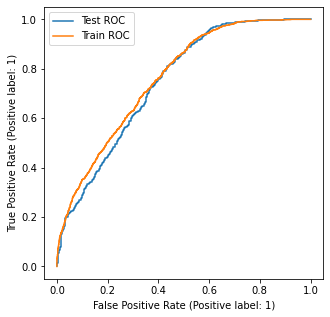

In [14]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(5,5))

RocCurveDisplay.from_predictions(y_test, y_test_pred, ax=ax, label='Test ROC')
RocCurveDisplay.from_predictions(y_train, y_train_pred, ax=ax, label='Train ROC')

plt.legend()
plt.show()

There are **four unique properties satisfied by the ROC curve** which we will discuss going forward:

1. Interpretable area under the curve (ROC AUC)
2. Invariance under class imbalance
3. Existence of a universal baseline
4. Convexity 

#### 1. Interpretable area under the curve (ROC AUC)

The area under the ROC curve (usually called ROC AUC or just AUC) is the most used metric in machine learning, yet many data scientists don't know its interpretation. We explain it (and prove why it is so) in what follows.

* Randomly take a point of the positive ($y=1$) class, and calculate its score $f(x_1)$
* Randomly take a point of the negative ($y=0$) class, and calculate its score $f(x_0)$

Claim: $$\boxed{\mathrm{ROC\;AUC} = \mathbb{P}(f(x_1) \geq f(x_0))},$$

that is: **the ROC AUC measures how likely it is that a point of the positive class scores higher than a point of the negative class**.

More formally, let $Z_0 = (f(X)|Y=0)$ and $Z_1 = (f(X)|Y=1)$. Then $\mathrm{ROC\;AUC} = \mathbb{P}(Z_1 \geq Z_0)$.

> Proof: by definition, $$\mathrm{ROC\;AUC} = \int_{\mathrm{FPR}=0}^{\mathrm{FPR}=1} \mathrm{TPR}\, d\mathrm{FPR}.$$
>It is natural to parameterize FPR and TPR via the threshold $\lambda$ since $\mathrm{TPR} = \mathbb{P}(f(X)\geq \lambda | Y=1)$ and $\mathrm{FPR} = \mathbb{P}(f(X) \geq \lambda | Y=0)$. This motivates us to define the *independent* random variables $$Z_1 = (f(X)|Y=1),\qquad Z_0 = (f(X)|Y=0),$$ for which $\mathrm{TPR}(\lambda) = \mathbb{P}(Z_1 \geq \lambda)$ for instance. This can be written as $$\mathrm{TPR}(\lambda) = \int_\lambda^\infty g_1(z) dz,\qquad \mathrm{FPR}(\lambda) = \int_\lambda^\infty g_0(z) dz$$ where $g_0, g_1$ are the PDFs of $Z_0$ and $Z_1$ respectively. Plugging these back into the definition of ROC AUC gives $$\mathrm{ROC\,AUC} = \int_{\mathrm{FPR}=0}^{\mathrm{FPR}=1} \mathrm{TPR}\, d\mathrm{FPR} = \int_{\lambda=\infty}^{\lambda=-\infty} \mathrm{TPR}(\lambda) \frac{ d \mathrm{FPR}(\lambda)}{d\lambda} d\lambda = \int_\infty^{-\infty} d\lambda \int_\lambda^\infty dz\, g_1(z) (-g_0(\lambda)),$$
where we have used the fundamental theorem of calculus in the last equality. Now one can equivalently write these iterated integrals as
$$\int_{-\infty}^\infty \int_{-\infty}^\infty \mathbf{1}_{z \geq \lambda} g_0(\lambda) g_1(z)\, dz d\lambda = \mathbb{E}[\mathbf{1}_{Z_1 \geq Z_0}] = \mathbb{P}(Z_1 \geq Z_0),$$
where we identify $g_0(\lambda)g_1(z)$ as the PDF for $(Z_0, Z_1)$ since these are independent variables.

Hence, in our example (where both train & test AUCs are close to 80.3%): there is a probability of 80.3% of a point in the positive class scoring higher than a point in the negative class. This is very good - 4 out of 5 times we will correctly sort them under the score.

**Numerically testing this claim**: let us run a series of samplings to check if we obtain a similar fraction to the ROC AUC we calculated above.

In [15]:
import pandas as pd

df = pd.DataFrame({'score': y_test_pred, 'label': y_test})
print(df.head().round(3).to_string())

n_samples = 10000

# randomly sample scores from class 1 and 0
class_1_score_samples = df[df['label']==1]['score'].sample(n_samples, replace=True, random_state=0)
class_0_score_samples = df[df['label']==0]['score'].sample(n_samples, replace=True, random_state=1)

# check how many times class 1 score higher
total = (class_1_score_samples.values >= class_0_score_samples.values).sum()

print("-> Percentage of times score for class 1 was higher than class 0: {0:.1f}%".format(100* total/n_samples))

   score  label
0  0.059      0
1  0.214      0
2  0.750      1
3  0.636      1
4  0.253      0
-> Percentage of times score for class 1 was higher than class 0: 74.5%


As we can see, this works - the percentage of times was very close to the 75.6% ROC AUC we got!

**Properties**:
* This characterization of the ROC AUC allows one to extract interesting insights on how the AUC will behave under some transformations. For example: given the ROC AUC of a classifier $f(x)$, how will it change if we change the classifier to $10 f(x)$? Or $f(x)^2$?
> Answer: it will stay the same. Since $\mathrm{ROC\,AUC} = \mathbb{P}(Z_1 \geq Z_0)$, any function $\phi$ applied to both sides of the inequality which does not change it will keep ROC AUC constant: $$(Z_1 \geq Z_0)\,=\,(\phi(Z_1) \geq \phi(Z_0)).$$ In particular this is true for functions like $\phi(Z) = 10Z$ or $\phi(Z) = Z^2$, which are monotonic functions. We can also see this numerically:

In [16]:
print("Original test ROC AUC: {0:.4f}".format(roc_auc_score(y_test, y_test_pred)))
print("Applying 10x: {0:.4f}".format(roc_auc_score(10*y_test, 10*y_test_pred)))
print("Applying square: {0:.4f}".format(roc_auc_score(y_test**2, y_test_pred**2)))

Original test ROC AUC: 0.7458
Applying 10x: 0.7458
Applying square: 0.7458


* This also explains why **ROC AUC is the best metric when one is interested in sorting values based on the score**. This is particularly the case in credit scoring, where one usually takes a list of potential individuals, scores them using a classification model, and sorts them (from good scores to bad scores) in order to shortlist those which are creditworthy. Notice that a person's absolute score does not matter - what matters is how high it scores on the list *compared to others*. In this sense, **a good model will have high AUC**, because it **ranks** points well.

* **ROC AUC is blind to intra-class score performance**. Suppose we have the following model (based on a real-life buggy model I once built):
  * For members of the positive class, it mostly predicts a random score between 70%-100%
  * For members of the negative class, it mostly predicts a score of 0%
  
  This model will have very high AUC, because there is a high chance that a point in the positive class scores higher than one in the negative class. However, this model does a **terrible** job regarding **scoring** within each class, since it is essentially random (for the positive class) and all identical to zero (for the negative class)

#### 2. Invariance under class imbalance

As we discussed in Chapter 1, class imbalance is one of the biggest sources of complexity in classification problems. We claim that the ROC AUC is "invariant under" class imbalance. What does it mean?

First, let us clarify one thing. Physicists reading this probably feel like invariance under something is a positive thing, but this is not necessarily true in machine learning.

Invariance under class imbalance means that the ROC AUC (and the ROC curve more generally) do not change if we change the relative proportion of the positive and negative classes. To see this, notice how
$$\mathrm{TPR} = \mathbb{P}(\hat y(x)=1|y=1) \approx \frac{\mbox{true positives}}{\mbox{all positives}}$$
$$\mathrm{FPR} = \mathbb{P}(\hat y(x)=1|y=0) \approx \frac{\mbox{false positives}}{\mbox{all negatives}};$$
the ratio $\mbox{all positives/all negatives}$ never appears. FPR and TPR only care about **intra-class ratios, but not inter-class**.

* The good thing about this is that AUC analysis works the same for balanced or imbalanced problems...
* The bad part is that if you blindly run AUC analysis *alone*, you are shortsighting yourself to class imbalance issues. You might think that a model is very good, when it actually is not!
> As a spoiler: metrics such as precision do depend on class imbalance, as we will see further down.

#### 3. Existence of a universal baseline

It is common knowledge that the **diagonal** line in the ROC plane is the baseline corresponding to a random classifier. More formally, consider that $\hat y$ is a biased coin toss (Bernoulli trial) with parameter $p$, which does not depend on $x$. Then the probability of $\hat y$ independs on whether $y=1$ or $0$, and we have

$$\mathrm{TPR} = \mathbb{P}(\hat y(x)=1 | y=1) = \mathbb{P}(\hat y = 1) = p$$
$$\mathrm{FPR} = \mathbb{P}(\hat y(x)=1 | y=0) = \mathbb{P}(\hat y = 1) = p$$

Thus this random classifier corresponds to the point $(p,p)$ in the plane. If we consider all possible $p$'s between 0 and 1, we get the 45 degree diagonal line.

> In practice, this will happen in the case of infinitely large sample size. Below we show the test ROC for the Logistic Regression model; a random classifier; and the theoretical random classifier. Notice how the "real" random classifier is noisy.

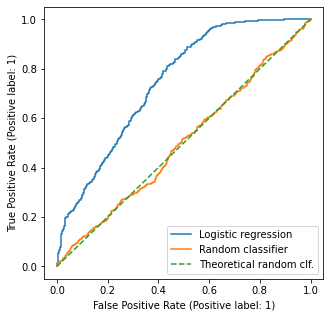

In [17]:
fig, ax = plt.subplots(figsize=(5,5))

# completely random classifier, generating random scores between [0,1]
np.random.seed(123)
y_pred_random = np.random.rand(*y_test_pred.shape)

# theoretical random classifier
p = np.linspace(0,1)

RocCurveDisplay.from_predictions(y_test, y_test_pred, ax=ax, label='Logistic regression')
RocCurveDisplay.from_predictions(y_test, y_pred_random, ax=ax, label='Random classifier')
plt.plot(p,p,linestyle='--', label='Theoretical random clf.')
plt.legend()
plt.show()

Because of this baseline, ROC AUC is theoretically bounded between 0.5 (area of the triangle below the 45 degree line) and 1. 

#### 4. Convexity

Convexity is a geometrical property of sets which will allow us to construct new (and better) classifiers based on old ones.

Suppose we have two estimators A and B, represented in the FPR/TPR plane as below (A in red, B in blue). Recall that an estimator is a function that outputs either 0 or 1.

**Convexity** allows us to build a whole family of estimators in the line segment between A and B (represented in a dotted line).

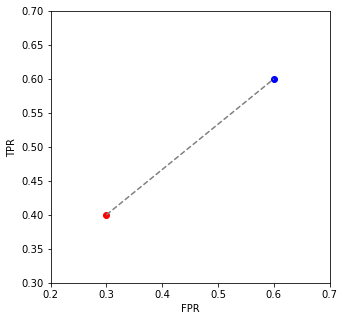

In [18]:
# THIS CODE CAN BE IGNORED
plt.subplots(figsize=(5,5))

# Classifier A
plt.scatter(x=[0.3], y=[0.4], color='red')

# Classifier B
plt.scatter(x=[0.6], y=[0.6], color='blue')

# All classifiers in-between
xx = np.linspace(0.3, 0.6)
yy = 2*xx/3 + 0.2
plt.plot(xx,yy, linestyle='--', color='gray')

# plot settings
plt.xlim(0.2, 0.7)
plt.ylim(0.3, 0.7)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

The procedure on how to do it (which is not as important as knowing we can do it!) follows below:

[**Theorem**] Let $c_A, c_B$ be the two binary classifiers (i.e. taking values in $\{0,1\}$). Let $(\mathrm{FPR_A, TPR_A})$ and $(\mathrm{FPR_B, TPR_B})$ denote the coordinates of the two classifiers. Consider a point $(\mathrm{FPR_*, TPR_*})$ in the segment between A and B. Let 

$$p = \mathrm{\frac{FPR_*-FPR_A}{FPR_B-FPR_A}}.$$

Then the classifier $c_*$ defined as

$$c_*(x) = \begin{cases}
c_A(x) & \mbox{with probability $1-p$}\\
c_B(x) & \mbox{with probability $p$}
\end{cases}$$

attains a FPR of $\mathrm{FPR_*}$ and TPR of $\mathrm{TPR_*}$.

> Proof: we do the calculation for FPR; that of TPR follows analogously. By definition, the FPR of $c_*$ is 
$$\begin{align}
\mathbb P (c_*(x) = 1 | y = 0) &= p\, \mathbb P (c_B(x)=1|y=0) + (1-p) \,\mathbb P(c_A(x)=1|y=0) \\
&= p \,\mathrm{FPR_B} + (1-p) \,\mathrm{FPR_A} = \mathrm{FPR}_*
\end{align}$$as claimed.

The importance of this result is that it gives an **optimal boundary** for a set of classifiers. Consider the situation below, where a new classifier $C$ (orange) lies in the region below the segment AB. $C$ is, *in any sense*, worse then the projection $C'$ (black) of C onto segment AB, since it has a higher TPR for the "cost" of the same FPR. 

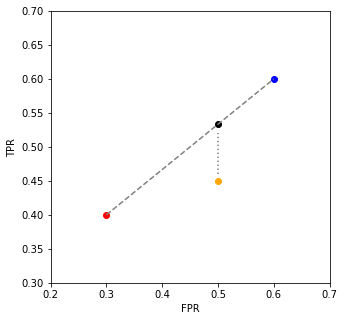

In [19]:
# THIS CODE CAN BE IGNORED
plt.subplots(figsize=(5,5))

plt.scatter(x=[0.3], y=[0.4], color='red')
plt.scatter(x=[0.6], y=[0.6], color='blue')

# Classifier C and C'
plt.scatter(x=[0.5], y=[0.45], color='orange')
plt.scatter(x=[0.5], y=[0.533], color='black')


# All classifiers in-between
xx = np.linspace(0.3, 0.6)
yy = 2*xx/3 + 0.2
plt.plot(xx,yy, linestyle='--', color='gray')
plt.axvline(0.5, ymin=0.40, ymax=0.55, linestyle=':', color='gray')

# plot settings
plt.xlim(0.2, 0.7)
plt.ylim(0.3, 0.7)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

Because of this, when given a classifier $f(x)$, one is allowed to take the **convex hull** of the ROC curve (think of it as "laying a rubber band" on top of the your points:

In [20]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url="https://i.stack.imgur.com/QWkFh.png")

We can build a function which creates the convex hull and also computs its AUC as below:

In [21]:
def hull_roc_auc(y_true, y_score):
    """
    Computes coordinates (TPR, FPR) and ROC AUC for the convex hull 
    of a ROC curve built from a ground truth y_true (0s and 1s) and 
    a vector of scores y_score
    """

    from sklearn.metrics import roc_curve, auc
    from scipy.spatial import ConvexHull

    fpr, tpr, thresholds = roc_curve(y_true, y_score)

    # add artificial vertex at (1,0)
    fpr, tpr = np.append(fpr, [1]), np.append(tpr, [0])

    points = np.array([fpr, tpr]).T
    hull = ConvexHull(points)

    # get vertices and remove artificial vertex
    vertices = np.array([points[v] for v in hull.vertices if not np.array_equal(points[v],np.array([1., 0.]))])
    fpr_hull, tpr_hull = vertices[:,0], vertices[:,1]

    # hull AUC
    hull_auc = auc(fpr_hull, tpr_hull)
    
    return hull_auc, fpr_hull, tpr_hull

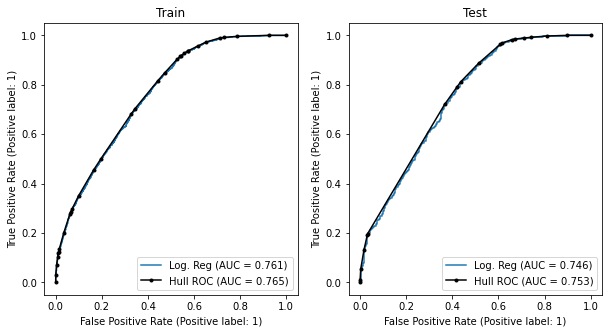

In [22]:
# Calculate variables for hull - train/test
hull_auc_train, fpr_hull_train, tpr_hull_train = hull_roc_auc(y_train, y_train_pred)
hull_auc_test, fpr_hull_test, tpr_hull_test = hull_roc_auc(y_test, y_test_pred)

## Plot
fig, ax = plt.subplots(figsize=(10,5), ncols=2)

# original ROC
original_auc_train = roc_auc_score(y_train, y_train_pred)
RocCurveDisplay.from_predictions(y_train, y_train_pred, ax=ax[0], 
                                 label=f'Log. Reg (AUC = {round(original_auc_train, 3)})')

original_auc_test = roc_auc_score(y_test, y_test_pred)
RocCurveDisplay.from_predictions(y_test, y_test_pred, ax=ax[1], 
                                 label=f'Log. Reg (AUC = {round(original_auc_test, 3)})')

# convex hull
ax[0].plot(fpr_hull_train, tpr_hull_train, label=f"Hull ROC (AUC = {round(hull_auc_train,3)})", marker='.', color='black')
ax[1].plot(fpr_hull_test, tpr_hull_test, label=f"Hull ROC (AUC = {round(hull_auc_test,3)})", marker='.', color='black')

# legends/labels
ax[0].legend(); ax[1].legend()
ax[0].set_title("Train"); ax[1].set_title("Test")
plt.show()

### Is this cheating?

No. It is a remarkable property of the "ROC space" (FPR vs TPR) that linear interpolation between classifiers yields a new classifier. Since we do not have access to the "true" distribution of $f(X)|Y$, the best we can do is use its empirical distribution and build the best possible ROC curve out of it.

### Takeaways

* The ROC curve represents a machine learning classifier in the TPR / FPR plane
* If it is not convex, it can be made convex by connecting points via line segments. This is equivalent to building new classifiers as probabilistic samplings of the endpoint classifiers
* The area under the ROC curve (ROC AUC) represents the likelihood that a point of the positive class scores higher than one in the negative class. It is bound between 0.5 and 1.0
* The ROC curve (and thus the ROC AUC) are invariant under rebalancing of the positive / negative classes. This is both good and bad

---

#### Appendix: properties of the ROC curve

There is an interesting characterization of the ROC curve based on the cumulative distribution functions (CDFs) of the variables

$$Z_0 = (f(X)|Y=0),\qquad Z_1 = (f(X)|Y=1)$$

Let $F_i(t) := \mathbb{P}(Z_i < t)$, for $i \in \{1,2\}$, denote the CDFs. We want to write the false & true positive rates with respect to these CDFs. Notice that, as functions of the threshold $\lambda$,

$$\begin{align}
\mathrm{TPR}(\lambda) &= \mathbb P(\hat y_\lambda(X) = 1 | Y = 1)\\
&= \mathbb P (f(X) \geq \lambda | Y = 1)\\
&= 1- \mathbb P (f(X) < \lambda | Y=1) = 1 - \mathbb P (Z_1 < \lambda)\\
&= 1 - F_1(\lambda)
\end{align}$$

Similarly,
$$\mathrm{FPR}(\lambda) = 1 - F_0(\lambda)$$

We can explicitly write $\mathrm{TPR}$ as a function of $\mathrm{FPR}$ if we invert the last expression for $\lambda$, obtaining $\lambda = F_0^{-1}(1-\mathrm{FPR})$; then
$$\boxed{\mathrm{TPR} = 1 - F_1(F_0^{-1}(1-\mathrm{FPR}))}$$

To simplify notation, call $x \equiv \mathrm{FPR}$ and $y \equiv \mathrm{TPR}$ (don't confuse with variables $X$ and $Y$; this is just a notation which reminds who goes in the vertical and horizontal axes). We can equivalently write

$$\begin{cases}
x &= 1 - F_0(\lambda)\\
y &= 1 - F_1(\lambda)
\end{cases} \qquad \mbox{or}\qquad y = 1 - F_1(F_0^{-1}(1-x))$$

From either expression, one can take the derivative and see that (calling $f_i(t) \equiv F_i'(t)$ the PDFs)

$$\frac{dy}{dx} = \frac{f_1(F_0^{-1}(1-x))}{f_0(F_0^{-1}(1-x))} \geq 0$$

since the PDFs are always non-negative, and so is their ratio. So we see that the ROC curve is necessarily non-decreasing.

It has, however, no obligation of being **concave** (= curved face-down), even if that is how we usually draw it. Taking a second derivative of the expression above yields

$$\frac{d^2y}{dx^2} = - \frac{f_1'}{f_0^2} + \frac{f_1 f_0'}{f_0^3}$$

where all quantities are calculated at $F_0^{-1}(1-x)$. Since derivatives of both $f_1$ and $f_0$ appear, and they can take any sign, there is no obvious sign for the expression above.

##### References:
Peter Flach, Meelis Kull, *Precision-Recall-Gain Curves: PR Analysis Done Right*, NIPS 2015

##### Further reading:
https://arxiv.org/pdf/1809.04808.pdf on the concavity of ROC curves 

---

# A necessary interlude: cross-validation for performance assessment

Suppose we have a training set and a test set. We train a model $f$ on the training set and want to evaluate the performance on the test set.

Any metric we create will be based on one (or more) confusion matrices - let's go with just one, to simplify, relative to a threshold $\lambda$. 

There is an error associated with our random split between train and test here. Had we chosen a different training/test set, we would most likely have obtained a slightly different confusion matrix, so our metrics would be different. 

The best way to deal with this variability is to use resampling methods: basically, sample different training/test sets, calculate metrics, and average them out as to (hopefully) get a metric closer to the real one.

In this section we discuss cross-validation and its variations as methods for estimating model performance. Over the next sections, we apply them to the calculation of different metrics.

> Some readers will realize that we chose to not include the bootstrap in our discussion here. It is simpler and more practical to implement (repeated) cross-validation, and both methods tend to converge to similar results. We leave the boostrap for the Appendix in the end of the book.

**Our recommendation** (before we get started in the zoo of different types of cross-validation): use `RepeatedStratifiedKFold`

We will use a custom dataset here, which has class imbalance. it is the credit card fraud dataset (https://www.kaggle.com/mlg-ulb/creditcardfraud), which we slightly process to make more amenable to training quickly.

```{python}
df = pd.read_csv('creditcard.csv')
df = df.drop(['Time', 'Amount'], axis=1)

# choose how imbalanced we want this to be
aux1 = df[df['Class']==1].sample(n=200, random_state=2)
aux0 = df[df['Class']==0].sample(n=40000, random_state=1)
df_reduce = pd.concat([aux1, aux0]).sample(frac=1.0, random_state=1)

# join them together and shuffle
df_reduce = pd.concat([aux1, aux0]).sample(frac=1, random_state=1)
```

This dataset has an imbalance rate of 0.49% of $y=1$ against 99.51% of $y=0$.

In [25]:
df = pd.read_parquet('Data/reduced_fraud_dataset.pqt')

# split into features and target
X_ = df.drop(['Class'], axis=1).values
y_ = df['Class'].values

### Simple cross-validation (K-fold CV)

In simple cross-validation, we fix a parameter $K$ (called the *number of folds*) which is usually chosen between 5-10. We then split our data into $K$ same-sized "chunks". The basic idea behind **K-fold cross-validation (CV)** is:

* For $k$ between 1 and $K$:
  * Train your data using all but the $k$-th chunk (called a *fold*), ie. using $K-1$ folds 
  * Test the data on the $k$-th fold alone
  * Calculate and store the performance on the $k$-th fold
* Read out the mean/error from the list of $K$ metrics you calculated


The `scikit-learn` implementation is particularly useful. What it does is that it gives the indices of the Numpy array / Pandas DataFrame which belong to the (test) single fold and the (teain) $K-1$ folds:

In [38]:
from sklearn.model_selection import KFold
from sklearn.ensemble import HistGradientBoostingClassifier

metrics_list = []  # empty list, will store computed metrics

cv = KFold(n_splits=10, shuffle=True, random_state=2)
for train_index, test_index in cv.split(X_):
    
    # split data into train and test
    X_train_cv, y_train_cv = X_[train_index], y_[train_index] # use X.iloc[train_index] if X is a DataFrame
    X_test_cv, y_test_cv = X_[test_index], y_[test_index]
    
    # train model
    cv_model = HistGradientBoostingClassifier(random_state=1)
    cv_model.fit(X_train_cv, y_train_cv)
    
    # create predictions (with predict_proba)
    y_test_pred_cv = cv_model.predict_proba(X_test_cv)[:,1]
    
    # compute any metric you'd like (we use AUC here for simplicity)
    metric = roc_auc_score(y_test_cv, y_test_pred_cv)
    metrics_list.append(metric)

In [39]:
print("Mean test AUC: {0:.3f}, error: {1:.3f}".format(np.mean(metrics_list), np.std(metrics_list)))

Mean test AUC: 0.852, error: 0.090


### Stratified CV

It is more common than not to have one (or more) variables which risk being left out during regular CV. A normal case is that of class imbalance, where your target $y$ may be 99% made of 0's and 1% made of 1's. In usual CV, there is a high chance that there will be one or more folds with no 1's appearing whatsoever. In these situations, estimation of AUC, for instance, will throw an error.

Stratification is the process by which we force our stratified class ($y$ here) to be evenly split among the folds.

> Notice that, despite one usually using the target for stratification, any feature(s) are also possible. This might be useful in cases where one customer segment, for example, is less represented than the others, and we want to ensure all folds have a similar distribution of customer segments.

The ONLY change to the code above is the parameter $y$ appearing inside the CV split:

```{python}
for train_index, test_index in cv.split(X, y):
```

We run a minimal example below:

In [40]:
from sklearn.model_selection import StratifiedKFold

metrics_list = []  # empty list, will store computed metrics

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)
for train_index, test_index in cv.split(X_, y=y_):
    
    # split data into train and test
    X_train_cv, y_train_cv = X_[train_index], y_[train_index] # use X.iloc[train_index] if X is a DataFrame
    X_test_cv, y_test_cv = X_[test_index], y_[test_index]
    
    # train model
    cv_model = HistGradientBoostingClassifier(random_state=1)
    cv_model.fit(X_train_cv, y_train_cv)
    
    # create predictions (with predict_proba)
    y_test_pred_cv = cv_model.predict_proba(X_test_cv)[:,1]
    
    # compute any metric you'd like (we use AUC here for simplicity)
    metric = roc_auc_score(y_test_cv, y_test_pred_cv)
    metrics_list.append(metric)

In [41]:
print("Mean test AUC: {0:.3f}, error: {1:.3f}".format(np.mean(metrics_list), np.std(metrics_list)))

Mean test AUC: 0.838, error: 0.056


### Repeated CV (+ stratified)

Instead of splitting the data into $K$ folds and running CV once, one could instead repeat this process $N$ times (each time splitting the data into different folds randomly) in order to sample not from $K$, but $N\times K$ different folds. This will allow us to hopefully reduce the estimate of error.

> Note: this repetition makes this method slower by a factor of $N$ compared to regular K-fold CV. Be careful.

If we use simple repeated CV, the ONLY change to the code above is the attributes `n_repeats` and `random_state` appearing inside the CV iterator definition:

```{python}
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=123)
```

We however choose to use the `RepeatedStratifiedKFold` version, which also adds a stratification. Then, we have to add `y` to the `cv.split` method:

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

metrics_list = []  # empty list, will store computed metrics

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=123)
for train_index, test_index in cv.split(X_, y=y_):
    
    # split data into train and test
    X_train_cv, y_train_cv = X_[train_index], y_[train_index] # use X.iloc[train_index] if X is a DataFrame
    X_test_cv, y_test_cv = X_[test_index], y_[test_index]
    
    # train model
    cv_model = HistGradientBoostingClassifier(random_state=1)
    cv_model.fit(X_train_cv, y_train_cv)
    
    # create predictions (with predict_proba)
    y_test_pred_cv = cv_model.predict_proba(X_test_cv)[:,1]
    
    # compute any metric you'd like (we use AUC here for simplicity)
    metric = roc_auc_score(y_test_cv, y_test_pred_cv)
    metrics_list.append(metric)

In [ ]:
print("Mean test AUC: {0:.3f}, error: {1:.3f}".format(np.mean(metrics_list), np.std(metrics_list)))

---

# A complement to the ROC: the gain curve

(also called the lift chart; different sources even mix up the names)

Despite the ROC AUC having a clear interpretation, it is often hard to interpret the ROC curve itself.
In this section we introduce the **gain curve**, which is much easier to interpret and has a clear deterministic relation to the ROC.

### Problem setup: credit scoring

Suppose you are a bank which has 1 million dollars to lend, in batches of $1000, to 1000 borrowers. These people must pay you that money back after one year. 

You have, however, 5000 people asking you for money, and you must decide which 1000 to give the money to.

The main risk here is that you lend money to someone who, for any reasons, does not pay it back (that is, *defaults on the payment*) after one year. There can be several reasons for a person to default: during that year, they lost their job and could not get the necessary money to pay you back; they work with agriculture, and their crops this year were lower than average due to bad weather, so they could not raise the capital to pay you back; they fled the country; etc. 

Your job as a bank is to somehow **score the possible borrowers** and only lend money to those individuals who are less likely to default. This is the standard problem in **credit scoring**. You ask the data scientists in your Credit team to build a classification model to help you make the best decision.

Your data scientists get back to you with a model after one month. Their report says:
> "We have developed a LightGBM model for binary classification. To train this model, we have used our internal database of past loans, over the past 5 years. The target of the model is whether a person has defaulted ($y=1$) on a payment to us during that period or not ($y=0$). There were 38 features employed, which can be split into 3 groups: (1) income & job related (2) previous year financial behavior (on-time payment of credit card bills and other loans) and (3) general personal information. The AUC of the model is 0.77 on the train test and 0.76 on the test set. Our recommendation is to **use the model's output score, sort it from lowest to highest (ie. lowest probability of default to highest probability) and give credit to the 1000 people with lowest score**."

What they recommend is for you to build the following ordered table, and give credit to the top 1000 entries. Call it `df`, a Pandas DataFrame:

|index|person_id | name | prob_default | 
|---|---|---|---|
|0|0123|brad pitt|0.010|
|1|2056|john williams| 0.020|
|2|0091|jackie chan|0.025|
|...|...|...|...|
|4998|9001|bob junior|0.975|
|4999|0918|alice mann|0.982|

The model looks promising. However, it does not answer all your questions. You write an email back to the Credit team with one question:

> Thanks for the good work. If I sort the way you said and only give credit to the first 100 people, how many will I get wrong (defaulted on)? What about the first 500? 1000? Tks

In other words: we want to know how many false negatives (people who will default [$y=1$] which we are wrongly saying are likely to not default [$\hat y =0$]) on the first $n$ people, or equivalently, the percentage of mistakes we will make. 

The simplest way to answer this is with a curve.

### The key question to answer before proceeding

In any problem you work on, you must answer the following question to yourself:
> Which of my entries [people, clients, products...] are "good", and which are "bad"?

In our case, $y=0$ is *good*: no defaults is better than having a default. **This is why we are sorting from low scores (=higher probability of being a 0) to high scores (=higher probability of being a 1)**.

In your use case, it could be the opposite:
> You might try to be solve the problem of identifying which of your employees is likely to leave the company over the next 3 months, in order to talk to them and provide an alternative (this is called an attrition problem). If $y=1$ represents an employee that is likely to leave, then you want to score from high scores to low scores.

### Gain curve I: when low scores are better (sorting from low to high scores)

Use a slight variation of the table above (we will also add more rows to make the example clearer):

|index|person_id | name | prob_default | y_actual|
|---|---|---|---|---|
|0|0123|brad pitt|0.010|0|
|1|2056|john williams| 0.020|0|
|2|0091|jackie chan|0.025|1|
|3|2221|eddie fung|0.029|0|
|4|9301|mark hamill|0.050|1|
|5|8913|lucy liu|0.060|0|
|...|...|...|...|...|
|4998|9001|bob junior|0.975|1|
|4999|0918|alice mann|0.982|1|

Again, recall that this table is ordered by `prob_default` (in ascending order). Notice that we've made two mistakes: for `jackie chan` and `mark hamill`, we are classifying them as "good payers" (=low probability of default), but their actual target was a 1, ie. a default. They are false negatives, which is exactly what we wanted to avoid.

To account for that mistake, we can build a new columns, called `cumulative_default`, which will simply count the number of defaults acumulated until that row:

`df['cumulative_default'] = df['y_actual'].cumsum()`

|index|person_id | name | prob_default | y_actual|cumulative_default|
|---|---|---|---|---|---|
|0|0123|brad pitt|0.010|0|0|
|1|2056|john williams| 0.020|0|0|
|2|0091|jackie chan|0.025|1|1|
|3|2221|eddie fung|0.029|0|1|
|4|9301|mark hamill|0.050|1|2|
|5|8913|lucy liu|0.060|0|2|
|...|...|...|...|...|...|
|4998|9001|bob junior|0.975|1|150|
|4999|0918|alice mann|0.982|1|151|

Notice that the `cumulative_default` column is non-decreasing. 

Notice that there are 151 defaults. We can obtain this number from `df['cumulative_default'].iloc[-1]` directly, or (in a more inefficient, but more robust way) from `df['y_actual'].sum()`. In either case, we can divide the `cumulative_default` by this number to obtain a `gain` column:
`df['gain'] = df['cumulative_default']/df['y_actual'].sum()`

|index|person_id | name | prob_default | y_actual|cumulative_default|gain|
|---|---|---|---|---|---|---|
|0|0123|brad pitt|0.010|0|0|0|
|1|2056|john williams| 0.020|0|0|0|
|2|0091|jackie chan|0.025|1|1|0.0066|
|3|2221|eddie fung|0.029|0|1|0.0066|
|4|9301|mark hamill|0.050|1|2|0.0132|
|5|8913|lucy liu|0.060|0|2|0.0132|
|...|...|...|...|...|...|...|
|4998|9001|bob junior|0.975|1|150|0.9934|
|4999|0918|alice mann|0.982|1|151|1.0000|

We can also normalize the `index` column (simply dividing each index by the total, 5000) and plot the normalized index vs. the `gain` column on the unit square.

**Visualizing**: we can use `y_test` and `y_test_pred` from before in order to visualize this curve. Let's pretend this is a credit scoring problem.

In [23]:
df = pd.DataFrame({'y_actual': y_test,
                   'prob_default': y_test_pred})

# sort from low to high scores
df = df.sort_values('prob_default', ascending=True)

df.head()

,y_actual,prob_default
144,0,0.017202
66,0,0.026143
117,1,0.035772
78,0,0.035773
24,0,0.040128


In [24]:
# build cumulative_default
df['cumulative_default'] = df['y_actual'].cumsum()
df['gain'] = df['cumulative_default']/df['y_actual'].sum()

# create index starting from 0 and normalize
df = df.reset_index(drop=True).reset_index()
df['index'] = df['index']/(df['index'].iloc[-1])
df = df.set_index('index')

This is the final table:

In [25]:
df.head()

,y_actual,prob_default,cumulative_default,gain
index,,,,
0.000000,0,0.017202,0,0.000000
0.005025,0,0.026143,0,0.000000
0.010050,1,0.035772,1,0.009901
0.015075,0,0.035773,1,0.009901
0.020101,0,0.040128,1,0.009901


#### How would a perfect gain curve be here?

Just before we plot: let us understand how a perfect gain curve would compare to ours. In a perfect gain curve, we would make no mistakes: the accumulated default column would be 0 until we reach the first person with $y=1$, and then grow linearly from there. 

#### What about a random classifier?
A random classifier, on the other hand, would linearly go from (0,0) to (1,1) (can you see why?)

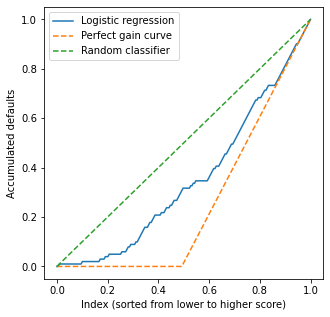

In [26]:
plt.subplots(figsize=(5,5))

# gain curve from the model
df['gain'].plot(label='Logistic regression')

# perfect gain
df_perfect = df.sort_values('y_actual')
df_perfect['cumulative_default'] = df_perfect['y_actual'].cumsum()
df_perfect['gain'] = df_perfect['cumulative_default']/df_perfect['cumulative_default'].iloc[-1]
df_perfect = df_perfect.reset_index(drop=True).reset_index()
df_perfect['index'] = df_perfect['index']/(df_perfect['index'].iloc[-1])
df_perfect = df_perfect.set_index('index')

df_perfect['gain'].plot(xlabel='Index (sorted from lower to higher score)', ylabel='Accumulated defaults', 
                       label='Perfect gain curve', linestyle='--')

# random gain
x = np.linspace(0,1)
plt.plot(x,x, linestyle='--', label='Random classifier')

plt.legend()
plt.show()

**Interpretation**:

Notice that the best possible curve is the lowest, whereas the worst one is the 45 degree diagonal. Our model is intermediate, not too low nor too high. The gain curve is monotonic by construction.
* Our model is not fantastic for *low scores*: the curve starts out flat but quickly starts to grow, meaning our model is making mistakes. It is worst for *medium scores*, where the curve grows fast while the ideal one should still be horizontal
* For high scores, where the ideal curve is slanted, the model performs well - it tends to grow very fast in that area.

**The gain curve is useful because it allows us to see how the model behaves across the whole data**. It gives us an interpretable curve which tells us how well we perform for entries with low/medium/high scores.

### Gain curve II: when high scores are better (sorting from high to low scores)

This case is exactly the opposite from the previous one. 

> A possible use case is in **product recommendation**. Suppose we have a model for whether a customer will be interested ($y=1$) or not ($y=0$) in a product, which will be recommended to them in our company's homepage. Then, we want to recommend the product to the clients with highest propensity to like the product, ie. those with higher score.

In [27]:
df = pd.DataFrame({'y_actual': y_test,
                   'prob_default': y_test_pred})

# sort from low to high scores
df = df.sort_values('prob_default', ascending=False)  ## THIS IS THE ONLY PLACE THAT CHANGES

# build cumulative_default
df['cumulative_default'] = df['y_actual'].cumsum()
df['gain'] = df['cumulative_default']/df['y_actual'].sum()

# create index starting from 0 and normalize
df = df.reset_index(drop=True).reset_index()
df['index'] = df['index']/(df['index'].iloc[-1])
df = df.set_index('index')

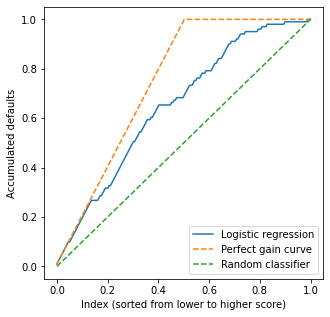

In [28]:
plt.subplots(figsize=(5,5))

# gain curve from the model
df['gain'].plot(label='Logistic regression')

# perfect gain
df_perfect = df.sort_values('y_actual', ascending=False) ## THIS IS THE ONLY PLACE THAT CHANGES
df_perfect['cumulative_default'] = df_perfect['y_actual'].cumsum()
df_perfect['gain'] = df_perfect['cumulative_default']/df_perfect['cumulative_default'].iloc[-1]
df_perfect = df_perfect.reset_index(drop=True).reset_index()
df_perfect['index'] = df_perfect['index']/(df_perfect['index'].iloc[-1])
df_perfect = df_perfect.set_index('index')

df_perfect['gain'].plot(xlabel='Index (sorted from lower to higher score)', ylabel='Accumulated defaults', 
                       label='Perfect gain curve', linestyle='--')

# random gain
x = np.linspace(0,1)
plt.plot(x,x, linestyle='--', label='Random classifier')

plt.legend()
plt.show()

**Interpretation**: of course, since we are using the exact same data as before, the conclusions must be the same. This curve is exactly the previous one, upside down.

### Area under the gain curve & its relation to ROC AUC

**The gain curves must be analyzed together with the ROC AUC**. It turns out they are both complementary and interpretable, providing a full picture of what is happening.

"Wait, what about the area under the gain curve?", one might ask. We now prove a very interesting result relating it to the ROC AUC: **one of them uniquely defines the other**, so the area under the gain curve doesn't really matter. We can use the ROC AUC instead.

**--- Mathematical interlude---**

**Proposition [equivalence of AUG and ROC AUC]**. Consider the gain curve II above (which is sorted from high to low scores). Let $\mathrm{AUG}$ denote the area under the gain curve, and let $\mathrm{AUC}$ denote the ROC AUC. Let $\pi_1 = \mathbb{P} (y=1)$ denote the fraction of the positive class. Then

$$\boxed{\mathrm{AUG} = \frac{\pi_1}{2} + (1-\pi_1) \mathrm{AUC}}\qquad \mbox{(high to low scores)}$$

> Proof: let us translate our construction of the gain curve into the language of probability. The Y axis contains the proportion of points correctly classified as 1, i.e. $\mathbb P(\hat y = 1|y=1)$ which is just the true positive rate. We have seen in the Appendix for the ROC curve that, for a fixed threshold $\lambda$, $$\mathrm{TPR}(\lambda) = 1 - F_1(\lambda)$$ where $F_1(\lambda) = \mathbb P (f(X) \leq \lambda | Y=1)$ is the CDF for the score $f(X)|Y=1$. Hence, we let $y(\lambda) = 1 - F_1(\lambda)$ be our Y axis. For the X axis, it represents the proportion ($\mathbb P$) of points with decreasing ($\geq \lambda$) score ($f(X)$). Hence, $x = \mathbb P (f(X) \geq \lambda) = 1 - F(\lambda)$ where the CDF $F(\lambda)$ is that of the unconditional score: $$F(\lambda) = \mathbb P (f(X) < \lambda),$$ which can also be written in terms of the conditionals $F_i$ via $$\begin{align}F(\lambda) &=  \mathbb P (f(X) < \lambda) = \mathbb P (f(X) < \lambda|Y=1) \mathbb{P} (Y=1) + \mathbb P (f(X) < \lambda|Y=0) \mathbb{P}(Y=0)\\
&= \pi_1 F_1(\lambda) + \pi_0 F_0 (\lambda)\end{align}.$$ Here $\pi_1 + \pi_0 = 1$ are the proportions of $Y=1$ and $Y=0$. We have thus written the gain curve as $$\begin{cases}x(\lambda) &=& 1 - F(\lambda) = 1 - \pi_1 F_1(\lambda) - \pi_0 F_0(\lambda)\\
y(\lambda) &=& 1 - F_1(\lambda)\end{cases}$$
To calculate $\mathrm{AUG}$, ideally we would like to write $y$ as a function of $x$ and integrate. This is possible if we invert $\lambda = \lambda(x)$ and plug it into the expression for $y$. This is hard since $\lambda$ appears both as the argument of $F_0$ and $F_1$. Instead, what we can do is to *write $x$ as a function of $y$ instead* and calculate the integral $\int x dy$ instead of $\int y dx$. These integrals are not the same, but they will be related as we show below. 

> We have $\lambda = F_1^{-1}(1-y)$. Plugging this into the equation for $x$ yields (calling $G(x)$ the gain curve and $G^{-1}(y)$ its inverse:
$$\begin{align}
x \equiv G^{-1}(y) &= 1 - \pi_1 F_1 (F_1^{-1}(1-y)) - \pi_0 F_0 (F_1^{-1}(1-y)) \\
&= 1 - \pi_1(1-y) - \pi_0 F_0(F_1^{-1}(1-y)).
\end{align}$$
In the Appendix for the ROC curve we saw that we could write it as $y = R(x) = 1 - F_1(F_0^{-1}(1-x))$. This is almost what we have, but the roles of $F_1$ and $F_0$ are shifted. We can actually invert this expression to get $$x \equiv R^{-1}(y) = 1 - F_0(F_1^{-1}(1-y)),$$ which matches nicely with the RHS above. Hence 
$$\begin{align}
G^{-1}(y) &= 1 - \pi_1 (1-y) - \pi_0 (1 - R^{-1}(y))\\
&=\pi_1 y + \pi_0 R^{-1}(y)\\
\Rightarrow \int_0^1 G^{-1}(y)dy  &= \frac{\pi_1}{2} + \pi_0 \int_0^1R^{-1}(y)dy
\end{align}$$
Now, both the ROC and gain curve live inside the unit square $[0,1]\times[0,1]$, which has area equal to 1, and have endpoints in $(0,0)$ and $(1,1)$. For any such function,
$$\int_0^1 f(x) dx + \int_0^1 f^{-1}(y) dy = 1.$$
We can then rewrite the equality above using $\mathrm{AUC}$ and $\mathrm{AUG}$:
$$(1-\mathrm{AUG}) = \frac{\pi_1}{2} + \pi_0 (1-\mathrm{AUC});$$
using that $\pi_0 = 1 - \pi_1$ and simplifying yields
$$\mathrm{AUG} = \frac{\pi_1}{2} + (1-\pi_1) \mathrm{AUC}$$
as claimed.

**Problem**: using the exact same logic as above (or just good old geometry) prove that for the gain curve I it holds that

$$\boxed{\mathrm{AUG} = 1 - \left[\frac{\pi_1}{2} + (1-\pi_1) \mathrm{AUC}\right]}\qquad \mbox{(low to high scores)}$$

**--- end of interlude---**

#### Numerically checking this

Let us us the DataFrame defined above (which has the gain with scores from high to low):

In [29]:
df.head()

,y_actual,prob_default,cumulative_default,gain
index,,,,
0.000000,1,0.986611,1,0.009901
0.005025,1,0.976603,2,0.019802
0.010050,1,0.974633,3,0.029703
0.015075,1,0.968521,4,0.039604
0.020101,1,0.965467,5,0.049505


We want to compare the area under the gain curve with the expression $\pi_1/2 +(1-\pi) \mathrm{AUC}$.

In [30]:
from sklearn.metrics import auc  # this is not roc_auc_score; it is just a function for numerical integration

pi1 = y_test.sum()/len(y_test) # proportion of 1's in the test dataset
print("Proportion of positive class (pi1): {0:.3f}".format(pi1))
aug = auc(x=df.index, y=df['gain'])
auc_ = roc_auc_score(y_test, y_test_pred)
print("\nRaw metrics:\n > AUG = {0:.3f}\n > AUC = {1:.3f}".format(aug, auc_))

aug_calc = pi1/2 + (1-pi1)*auc_
print("\nCalculated AUG: {0:.3f}".format(aug_calc))
print(" > Difference between AUG and calculated version: {0:.3f}".format(np.abs(aug-aug_calc)))

Proportion of positive class (pi1): 0.505

Raw metrics:
 > AUG = 0.653
 > AUC = 0.803

Calculated AUG: 0.650
 > Difference between AUG and calculated version: 0.003


We can see that indeed both are very close (difference in the third decimal place), as expected.

##### References
Chris J. Lloyd, *A Note on the Area under the Gains Chart*. International Journal of Statistics in Medical Research, 2018, 7, 66-69 

Max Kuhn, Kjell Johnson, *Applied Predictive Modeling*. Springer, 2016, pp. 265-266

### Wrap-up

We have seen that the gain curve and the ROC are cousins displaying complementary information:

| | ROC | Gain|
|---|---|---|
|Interpretable area| Yes, ROC AUC =$\mathbb P (Z_1 \geq Z_0)$ | Yes, but determined by ROC AUC|
|Interpretable curve| Hard to interpret | Easy to interpret|

It is therefore always recommended to look at the ROC AUC for its capability of showing predictive power (and because it is the industry reference), but at the same time to study the Gain curve to see how the model performs for low / middle / high scores.

# Number 2. Precision, recall, and $F$-scores

### Motivation: a Covid test

What is the difference between

$$\mathbb P (\hat y = 1|y=1) \qquad \mbox{and}\qquad \mathbb P(y=1|\hat y=1)?$$

The first one measures, *out of all points in the positive class*, how many we got right. The second one measures, *out of all points predicted to be in the positive class*, how many were actually positives.

These quantities are not the same. Writing them like this makes this fact obvious, but it is surprising how many times we can mix them up in conversation. For instance:

> I just got a positive in my Covid test. They say that it is right 99% of the time when you are infected, so I am probably infected.

The conclusion above is a falacy, because we do not have enough data. Does the person mean

$$\mathbb P (\mbox{test gives positive | you have Covid}) = 99\%$$
or
$$\mathbb P (\mbox{ you have Covid | test gives positive}) = 99\%?$$

These two cases are completely different, as we show below.

> **(Review: Bayes' rule**). We are entering the domain where Bayes' theorem becomes important. It is the rewriting of the definition of conditional probability as follows:
$$\mathbb P(A|B) = \frac{\mathbb P(A\cap B)}{\mathbb P(B)} = \frac{\mathbb P(B|A) \mathbb P(A)}{\mathbb P (B)}$$
where one sometimes writes the denominator as a sum over all possible dependencies of $B$: 
$$\mathbb P (B) = \sum_{A'} \mathbb P(B|A') \mathbb P(A')$$

For instance, in the case above, let $y=1$ denote if someone has Covid, and $\hat y = 1$ denote that they tested positive. 

Let us assume that 

$$\mathbb P (\hat y=1 | y=1) = 99\%$$


We can write, using Bayes' theorem,

$$\mathbb P(y=1|\hat y=1) = \frac{\mathbb P (\hat y=1 | y=1) \mathbb P(y=1)}{\mathbb P (\hat y=1)}$$

or, expanding the denominator,

$$\begin{align}
\mathbb P(y=1|\hat y=1) &= \frac{\mathbb P (\hat y=1 | y=1) \mathbb P(y=1)}{\mathbb P (\hat y=1|y=0) \mathbb P(y=0) + \mathbb P(\hat y = 1|y=1) \mathbb P(y=1)}\\
&= \frac{1}{\displaystyle1 + \frac{\mathbb P(\hat y=1 | y=0) \mathbb P(y=0)}{\mathbb P(\hat y=1|y=1) \mathbb P(y=1)}}
\end{align}$$

Assume that:
* 1% of the population is infected, ie. $\mathbb P(y=1) = 0.01$ and $\mathbb P(y=0) = 0.99$
* If you are infected, there is a 99% chance the test will come back positive: $\mathbb P(\hat y=1|y=1) = 0.99$
* If you are not infected, there is a 5% chance the test will come back as a (false) positive: $\mathbb P(\hat y=1|y=0) = 0.05$

Then, from the expression above we get
$$\mathbb P(y=1|\hat y=1) = \frac{1}{\displaystyle 1 + \frac{0.05 \times 0.99}{0.99 \times 0.01}} = \frac 16 \approx  16.7\%$$ 

that is, if your test comes back positive, there is only a 16.7% chance that you actually have Covid.

This is a *significantly* smaller number than the 99% we started with (and also shows why a "test with 99% confidence" does not mean much by itself). This is why $\mathbb P (\hat y = 1|y=1)$ and $\mathbb P(y=1|\hat y=1)$ are *very* different things.

> One might argue that the test is bad. It is not. To see why, think about it this way. Without having taken a test, your prior chance of being infected was 1%. Now that you have taken the test, this chance grows by **almost 17 times**. This is a huge growth! It is just not a definitive answer. Indeed, one could **take the test again** and see how much the probability changes. 

> (**Problem**) Suppose we test again, and again we get a positive. Convince yourself that we can calculate the new probability of being infected by formally starting out from the exact same formula above but changing the prior probability of being infected to $\mathbb P (y=1) = 1/6$ (which implies $\mathbb P(y=0) = 5/6$), yielding
$$\mathbb P(y=1|\hat y_1=1, \hat y_2 = 1) = \frac{1}{\displaystyle 1 + \frac{0.05\times 5/6}{0.99 \times 1/6}} \approx 80\%,$$which is now much higher. If we further test again this number increases to 99%, and so on. 

### Precision and recall

$$
\boxed{\mathrm{Recall} = \mathbb P (\hat y = 1|y=1)}$$
$$\boxed{\mathrm{Precision} = \mathbb P(y=1|\hat y=1)}$$

For the Covid test above, it had a recall of 99% and a precision of 16.7% for the positive class.
> For multiclass models (which generalize the binary case we see here), one calculates precision/recall for each class. For instance, if you have an image classification model which classifies an image into $\{\mathrm{dog, cat, horse, penguin}\}$ then you should calculate precision/recall for each class: $$\mathrm{Recall_{dog}} = \mathbb P (\hat y = \mathrm{dog} | y = \mathrm{dog}),\quad \mathrm{Recall_{cat}} = \mathbb P (\hat y = \mathrm{cat} | y = \mathrm{cat})$$ and so on.

### The $F$-scores

Recall that, given two numbers $a, b$, their **harmonic mean** is the number $c$ defined via

$$\frac 1c = \frac 12 \left( \frac 1a + \frac 1b \right),$$

or explicitly

$$c = \frac{2}{1/a + 1/b} = \frac{2ab}{a+b}$$

(if any of the numbers is 0, the harmonic mean is undefined; if any of them is infinite, the harmonic mean will be the finite one left, as can be seen by taking the limit in the first definition)

We define the **$F_1$ score** as the harmonic mean of precision and recall:

$$\boxed{\frac{1}{F_1} = \frac 12 \frac{1}{\mathrm{Precision}} + \frac 12 \frac{1}{\mathrm{Recall}}}$$

More generally, we define the **$F_\beta$ score** as a weighted harmonic mean between precision and recall:

$$\frac{1}{F_\beta} = \frac{1}{1+\beta^2} \frac{1}{\mathrm{Precision}} + \frac{\beta^2}{1+\beta^2}\frac{1}{\mathrm{Recall}}$$

For $\beta = 1$ we retrieve $F_1$, which weighs precision and recall equally; for $\beta > 1$ we give a higher importance to recall, whereas for $\beta < 1$ we place more importance on precision.

A relevant question is then:

### Should I prioritize precision or recall? Which matters most?

A rule-of-thumb to keep in mind is:

$$\mathrm{Precision \sim } \quad \mbox{focus on minimizing false positives}$$
$$\mathrm{Recall \sim } \quad \mbox{ focus on minimizing false negatives}$$

False positives and false negatives are never what we wish for, but there is always a trade-off on which is worse for the problem at hand. Consider the situations below:

**Treatment for a disease.**
You work in medical research, and you are developing a test for a specific colon disease. This disease is lethal - if a person has it and is not treated there is a high chance they will die. 

There already exists a very accurate test to diagnose this disease, but it is time-consuming and very uncomfortable for the patient. Your company wants to create a cheaper and less uncomfortable test, which can be done quickly at a doctor's office, but will also be less accurate. The idea here is that, if a patient tests positive under this quicker test, only then will they take the more time-consuming and uncomfortable one, as a means of validation.

> **Question**: which do you prioritize, precision or recall?

> Solution: consider what happens if you have a false negative (=the patient is sick, but your test returns negative). Since the disease is lethal, this means this patient might die. Now consider a false positive (=patient is not sick, but your test returns positive). Then they will need to go through an uncomfortable test, but they will not die. In this case, **false negatives are much worse than false positives**. Because of this, our focus is on high recall.

**Product recommendation**. You work in an e-commerce company, and are developing a product recommendation model. Basically, when the user enters your homepage, you want to recommend products to them based on their profile, previous purchases etc which will maximize the chances they will buy again. The product recommendations will be displayed, 5 at a time, in a "Recommended for you" tab.

Usually, product recommendation models are not just binary classifiers, but for the sake of simplicity let's assume they are. Then, our model is a classification model which outputs a score: high scores indicate a user is likely to purchase something, and low scores mean the opposite.

> **Question**: which do you prioritize, precision or recall?

> Solution: a false positive here means a product which you recommend, but the user is not really likely to buy. A false negative is a product they would have liked, but you don't recommend. If you want to maximize the likelihood a user will buy a product, you want to make sure you only show them the top 5 products they will like: few false positives. It is OK, however, to have products that they would like but you don't end up recommending. What you want to avoid is that they enter the page, don't find anything they like, and leave. **False positives are worse than false negatives here**, so the focus is on high precision.

To-dos:
    
* Threshold-independent metrics
* Threshold-dependent metrics
* Finding optimal thresholds
* Do we really use the convex hull?
* Three important models
	- Logistic regression
	- XGBoost / LightGBM / GradientBoostingClassifier
	- Neural nets
* Model calibration
* Defining a target
* Uncertainty measures (CV / bootstrap)
* Interpretability (SHAP with logits)
	

# Further readings 

## Bootstrap for model assessment

Suppose you have the following dataset with 20 observations:

In [53]:
np.random.seed(3)
x = np.random.randn(20)
x

array([ 1.78862847,  0.43650985,  0.09649747, -1.8634927 , -0.2773882 ,
       -0.35475898, -0.08274148, -0.62700068, -0.04381817, -0.47721803,
       -1.31386475,  0.88462238,  0.88131804,  1.70957306,  0.05003364,
       -0.40467741, -0.54535995, -1.54647732,  0.98236743, -1.10106763])

As we can see, this data was actually generated from a normal distribution centered in zero (with unit variance), but let us suppose we don't know this. We might ask two relevant questions:
* What is a good estimate for the *mean value* of the data?
* What is a good estimate for the *error* on that estimate of the mean?

The naive answer is: calculate the mean and standard deviation, done:

In [54]:
print("Mean: {0:.2f}, std: {1:.2f}".format(x.mean(), x.std()))

Mean: -0.09, std: 0.97


Ideally, we would like to get more data to reduce the variance - we know from the central limit theorem that, whatever the distribution that generated the data, the mean will asymptotically (as $n\to\infty$ where $n$ is the total amount of data) behave as a normal variable with variance decreasing as $1/n$.

If we cannot get more data, what else can we do? It turns out that, if we **sample $n$ points (with replacement) from the original data**, this new dataset (called a **boostrap sample**) will be distributed equally to the original data. In other words, this "new" dataset can be used as an equivalent (but different) to the "old" one, on an equal footing.

The **boostrap method** consists of creating many (say, thousands) such boostrap samples, and using the average calculated on each one of them as an estimate of the true average - in other words, using an average of averages.

> One might wonder: why do we need to introduce random samplings? Couldn't we just calculate all possible boostrap samples and average out? In practice no - this is an exponentially large set. If you have $n$ data points, there will be $n^n$ boostrap samples. In our $n=20$ case, $$n^n = 20^{20} = 10^{20 \log_{10} 20} \approx 10^{26}$$ is a tremendously large, and computationally infeasible, number.

We can use the `resample` method in scikit-learn to calculate boostrap samples:

In [55]:
from sklearn.utils import resample

resample(x, random_state=1)

array([-0.35475898,  0.88462238,  0.88131804, -0.04381817, -0.47721803,
        0.88462238, -0.35475898, -0.40467741,  1.78862847, -0.54535995,
        0.43650985,  0.88131804, -0.62700068,  1.70957306, -0.08274148,
        0.98236743, -0.35475898,  0.98236743,  0.88462238, -1.31386475])

Let us show how boostrap samples can be used to better estimate the sample mean and error. We will create $N = 5000$ samples:

In [68]:
means = np.array([resample(x, random_state=seed).mean() for seed in range(5000)])

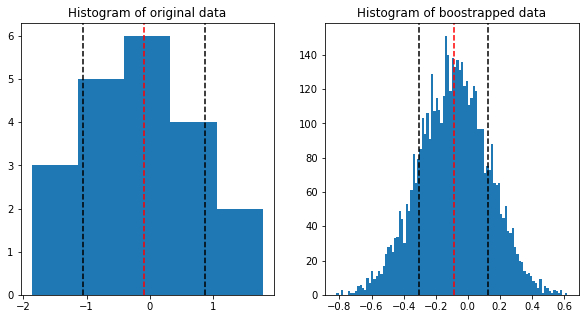

In [73]:
# plot original data and boostrapped data
fig, ax = plt.subplots(figsize=(10,5), ncols=2)

# original data
ax[0].hist(x, bins=5)
ax[0].set_title("Histogram of original data")
ax[0].axvline(x.mean(), linestyle='--', color='red')
ax[0].axvline(x.mean()+x.std(), linestyle='--', color='black')
ax[0].axvline(x.mean()-x.std(), linestyle='--', color='black')


# boostrapped data
ax[1].hist(means, bins=100)
ax[1].set_title("Histogram of boostrapped data")
ax[1].axvline(means.mean(), linestyle='--', color='red')
ax[1].axvline(means.mean()+means.std(), linestyle='--', color='black')
ax[1].axvline(means.mean()-means.std(), linestyle='--', color='black')

plt.show()

In [59]:
print("Mean: {0:.2f}, std: {1:.2f}".format(means.mean(), means.std()))

Mean: -0.09, std: 0.22


Notice how, despite the mean itself not changing, the standard deviation is much smaller than that of the original data! 

### The boostrap in machine learning

One could consider using boostrap in machine learning in the following (naive) way:
* Create empty list
* For *i* between 0 and N:
  * Create a bootstrap sample X_boot, y_boot
  * Split into train and test sets (say, test size 30%)
  * Instantiate classifier and train on X_train, y_train
  * Calculate metrics from X_test, y_test
  * Append metrics to list
* Compute average / standard deviation of metrics

The problem of this approach is that, since boostrap works with sampling *with replacement*, it is likely that there will be points which are simultaneously in the training and the test set. These points will make the model performance appear to be higher than it actually is.

TODO - continue this session